In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.environ.setdefault('GLUE_SETTINGS_MODULE', 'settings')

'settings'

In [3]:
import gglu5 as gnet
from flowfairy.conf import settings

In [4]:
batch_size = settings.BATCH_SIZE
samplerate = settings.SAMPLERATE

In [5]:
x = tf.placeholder(tf.float32, [1, samplerate])
cls = tf.placeholder(tf.int32, 1)

In [6]:
with tf.variable_scope('network'):
    net = gnet.conv_net(x, cls, None)

conv1:  Tensor("network/MaxPool2D/MaxPool:0", shape=(1, 8192, 1, 4), dtype=float32)
embedded: Tensor("network/concat:0", shape=(1, 8192, 1, 6), dtype=float32)
conv2:  Tensor("network/MaxPool2D_1/MaxPool:0", shape=(1, 4096, 1, 8), dtype=float32)
conv3:  Tensor("network/glu_conv3_2/mul:0", shape=(1, 4096, 1, 16), dtype=float32)
d2sp:  Tensor("network/DepthToSpace:0", shape=(1, 16384, 4, 1), dtype=float32)
conv4:  Tensor("network/glu_conv4_2/mul:0", shape=(1, 16384, 1, 16), dtype=float32)
conv5:  Tensor("network/glu_conv5/mul:0", shape=(1, 16384, 1, 256), dtype=float32)
out:  Tensor("network/Reshape_1:0", shape=(1, 16384, 256), dtype=float32)


In [7]:
saver = tf.train.Saver()

In [8]:
sess = tf.InteractiveSession()

In [9]:
saver.restore(sess, 'logs/GGLU5_embed2_md_bna.ckpt-90000')#tf.train.latest_checkpoint('logs'))

INFO:tensorflow:Restoring parameters from logs/GGLU5_embed2_md_bna.ckpt-90000


In [10]:
coll = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
c1uw = coll[0]

In [11]:
def plot_filter(var, flt):
    plt.plot(var.eval()[:,0,0,flt])

In [12]:
#plot_filter(c1uw, 0)
#plot_filter(c1uw, 1)
#plot_filter(c1uw, 2)
#plot_filter(c1uw, 3)
#plt.show()

In [13]:
for v in coll:
    print(v)

<tf.Variable 'network/conv1_1_unit/weights:0' shape=(256, 1, 1, 4) dtype=float32_ref>
<tf.Variable 'network/conv1_1_unit/BatchNorm/beta:0' shape=(4,) dtype=float32_ref>
<tf.Variable 'network/conv1_1_gate/weights:0' shape=(256, 1, 1, 4) dtype=float32_ref>
<tf.Variable 'network/conv1_1_gate/BatchNorm/beta:0' shape=(4,) dtype=float32_ref>
<tf.Variable 'network/conv1_2_unit/weights:0' shape=(256, 1, 4, 4) dtype=float32_ref>
<tf.Variable 'network/conv1_2_unit/biases:0' shape=(4,) dtype=float32_ref>
<tf.Variable 'network/conv1_2_gate/weights:0' shape=(256, 1, 4, 4) dtype=float32_ref>
<tf.Variable 'network/conv1_2_gate/biases:0' shape=(4,) dtype=float32_ref>
<tf.Variable 'network/embedding/embedding:0' shape=(200, 2) dtype=float32_ref>
<tf.Variable 'network/conv2_1_unit/weights:0' shape=(128, 1, 6, 8) dtype=float32_ref>
<tf.Variable 'network/conv2_1_unit/biases:0' shape=(8,) dtype=float32_ref>
<tf.Variable 'network/conv2_1_gate/weights:0' shape=(128, 1, 6, 8) dtype=float32_ref>
<tf.Variable '

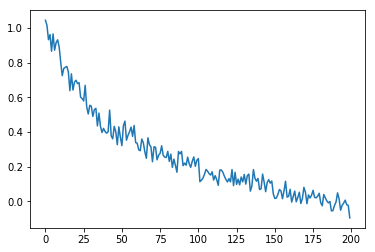

0.321292
0.338879


In [14]:
embedding = coll[8][:,0]
#print(embedding)
plt.plot((embedding.eval()))
plt.show()

print(embedding.eval()[50])
print(embedding.eval()[64])

In [15]:
def classify(val):
    val = (val-np.min(val))/(np.max(val)-np.min(val))
    return np.floor(val*255)

def getid(frq):
    limits = settings.FREQUENCY_LIMIT
    count = settings.CLASS_COUNT
    step = (limits[1] - limits[0]) // count
    return (frq-limits[0])//step

def getfrq(fid):
    limits = settings.FREQUENCY_LIMIT
    count = settings.CLASS_COUNT
    step = (limits[1] - limits[0]) // count
    return limits[0] + step*fid

In [16]:
with tf.variable_scope('network', reuse=True):
    tnet = gnet.conv_net(x, cls, None, is_training=True)

conv1:  Tensor("network_1/MaxPool2D/MaxPool:0", shape=(1, 8192, 1, 4), dtype=float32)
embedded: Tensor("network_1/concat:0", shape=(1, 8192, 1, 6), dtype=float32)
conv2:  Tensor("network_1/MaxPool2D_1/MaxPool:0", shape=(1, 4096, 1, 8), dtype=float32)
conv3:  Tensor("network_1/glu_conv3_2/mul:0", shape=(1, 4096, 1, 16), dtype=float32)
d2sp:  Tensor("network_1/DepthToSpace:0", shape=(1, 16384, 4, 1), dtype=float32)
conv4:  Tensor("network_1/glu_conv4_2/mul:0", shape=(1, 16384, 1, 16), dtype=float32)
conv5:  Tensor("network_1/glu_conv5/mul:0", shape=(1, 16384, 1, 256), dtype=float32)
out:  Tensor("network_1/Reshape_1:0", shape=(1, 16384, 256), dtype=float32)


In [17]:
pred = tf.argmax(net, 2)


In [18]:
tpred = tf.argmax(tnet, 2)

In [29]:
frqid = 100
frq = getfrq(frqid)
print(frq)

bfrq = getfrq(50)
print(bfrq)

myrange = np.arange(samplerate) * 2 * np.pi / samplerate
mysine = np.sin(myrange * frq)
mysine2 = np.sin(myrange * bfrq)
noise = np.random.uniform(-0.5, 0.5, samplerate)

#plt.plot(mysine)
#plt.show()

320
220


In [30]:
b = np.array([mysine+mysine2+noise])
y = np.array([frqid])
#b=np.tile(classify(mysine+mysine2),(64,1))
#y=np.arange(136,200)
run = sess.run(tpred, feed_dict={x: b, cls: y})

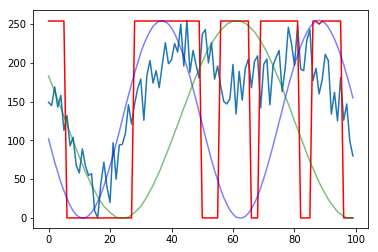

In [31]:
plt.plot(classify(b[0][1000:1100]))
plt.plot(run[0][1000:1100], 'r')
plt.plot(classify(mysine)[1000:1100], 'b', alpha=0.5)
plt.plot(classify(mysine2)[1000:1100], 'g', alpha=0.5)
plt.show()

In [22]:
print(getid(350))
print(getid(650))

print(120+3*64)
print(120+3*50)


115
265
312
270
